<a href="https://colab.research.google.com/github/shaevitz/MOL518-Intro-to-Data-Analysis/blob/main/Lecture_13/MOL518_Lecture13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In colab run this cell first to setup the file structure!
%cd /content
!rm -rf MOL518-Intro-to-Data-Analysis

!git clone https://github.com/shaevitz/MOL518-Intro-to-Data-Analysis.git
%cd MOL518-Intro-to-Data-Analysis/Lecture_13

/content
Cloning into 'MOL518-Intro-to-Data-Analysis'...
remote: Enumerating objects: 905, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 905 (delta 125), reused 116 (delta 104), pack-reused 745 (from 1)
Receiving objects: 100% (905/905), 27.48 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (375/375), done.
/content/MOL518-Intro-to-Data-Analysis/Lecture_13



# Lecture 13: Curve Fitting Beyond Linear Regression

In this class, we will learn how to fit nonlinear curves to biological datasents and plot them in Python using Jupyter Notebooks running in Google Colab.

**Learning objectives**
- Understand when and why nonlinear models are needed (vs. linearization)
- Learn how to fit nonlinear models to data using `scipy.optimize.curve_fit`
- Interpret parameter estimates and covariance
- Evaluate the curve fits using residuals, $R^2$, and Akiko Information Criterion (AIC)
- Apply curve fitting to common biological models: exponential growth, Michaelis–Menten kinetics, Hill equations

> Tip: Run cells in order. Each section is independent but reuses utility functions defined below.



## Setup & utilities
This cell imports libraries and defines helper functions for metrics and plotting.


In [2]:
# import necessary libraries: numpy, pandas, matplotlib, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Matplotlib defaults
plt.rcParams.update({
    "figure.figsize": (6.5, 4.2),
    "axes.grid": True,
    "grid.alpha": 0.25,
})

# Reproducibility
np.random.seed(42) # use the same random seed each time for reproducible results

# ---------- Helper functions ----------

# this function calculates the r^2 value for the curve fit
def r2_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

# this function calculates the Akaike Information Criterion (AIC) for the fit
def aic(y_true, y_pred, k):
    # Akaike Information Criterion for least-squares fits.
    # k = number of free parameters
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)
    rss = np.sum((y_true - y_pred)**2)
    return 2*k + n * np.log(rss / n)

# this function plots the curve fits
def plot_fit(x, y, model, popt, xlabel="x", ylabel="y", title="Fit"):
    x = np.asarray(x)
    y = np.asarray(y)
    xs = np.linspace(np.min(x), np.max(x), 400)
    plt.scatter(x, y, s=32, alpha=0.9, label="Data")
    plt.plot(xs, model(xs, *popt), c="crimson", lw=2.0, label="Model fit")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# this function will help us plot the residuals after doing curve fitting
def plot_residuals(x, residuals, xlabel="x"):
    plt.axhline(0, color='k', lw=1, alpha=0.6)
    plt.scatter(x, residuals, s=28)
    plt.xlabel(xlabel)
    plt.ylabel("Residuals (y - ŷ)")
    plt.title("Residual plot")
    plt.show()

print("Libraries imported & utilities ready.")


Libraries imported & utilities ready.



## Motivation: Why nonlinear models?
Many biological relationships are nonlinear:

- **Exponential Growth/decay:** $y = A e^{kt}$ or logistic growth
$y = \frac{K}{1 + e^{-r(t-t_0)}}$

- **Enzyme kinetics (Michaelis–Menten):**
$v = \frac{V_\max [S]}{K_m + [S]}$

- **Cooperative binding (Hill):**
$Y = \frac{[L]^n}{K_d^n + [L]^n}$

Historically, researchers *linearized* these models (e.g., Lineweaver–Burk) but that can *distort errors* and bias estimates. The current best practice is to fit the nonlinear model *directly* to the data by using least squares or maximum likelihood methods.

For the purposes of this class, we will focus on least squares approaches, as they are simpler to teach, and are the method of choice for simple nonlinear curve fitting.

**Note:** We discussed least squares methods in the last class in the context of linear fitting, but it is also really useful for nonlinear fitting! The way the error is calculated is the same.



## Nonlinear regression with `scipy.optimize.curve_fit`
Key ideas:
- Define a Python function `f(x, *theta)` for your model.
- Provide **initial guesses** `p0` (crucial for convergence).
- Optional **bounds** can constrain parameters (e.g., positivity).
- `curve_fit` returns `popt` (best-fit params) and `pcov` (covariance matrix).
- Standard errors are `se = sqrt(diag(pcov))` if the model is well-specified.



### Example 1: Exponential growth

For this very simple example, we will be using synthetic data, generated by adding random, normally distributed noise to the data.

Synthetic data: $OD_{600} = A e^{kt} + \epsilon$

Here, $\epsilon$ denotes normally distributed noise that we are adding to the data to simlulate measurment error in experimental data.


A = 0.026 ± 0.003
k = 0.412 ± 0.013
R^2 = 0.978
AIC = -270.92


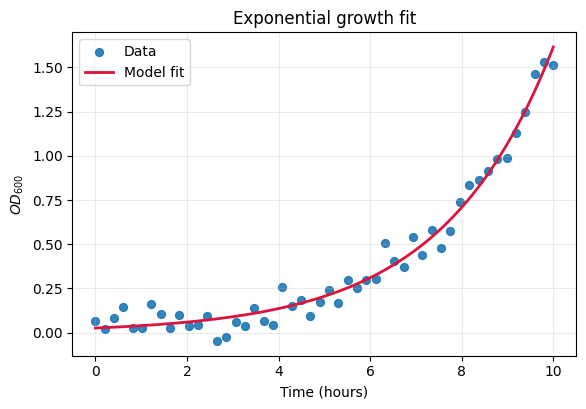

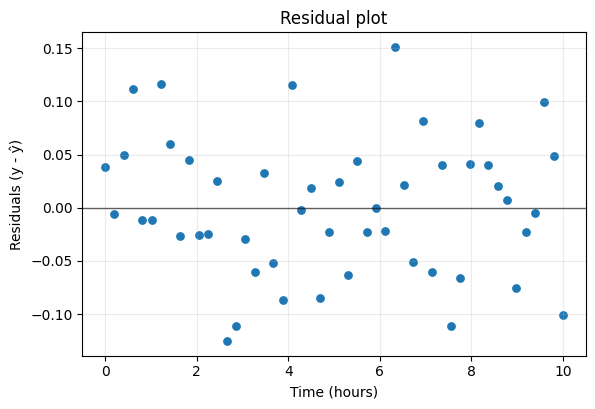

In [4]:

# ----- Generate synthetic data -----
t = np.linspace(0, 10, 50)
A_true, k_true = 0.03, 0.40
OD600 = A_true * np.exp(k_true * t) + np.random.normal(0, 0.07, size=t.size)

# ----- Model -----
def exp_model(t, A, k):
    return A * np.exp(k * t)

# ----- Fit -----
pnot = [1.0, 0.1]  # initial guesses
popt, pcov = curve_fit(exp_model, t, OD600, p0=pnot)
A_fit, k_fit = popt # this unpacks popt, which is the output of the curve fitting function
perr = np.sqrt(np.diag(pcov))

print(f"A = {A_fit:.3f} ± {perr[0]:.3f}")
print(f"k = {k_fit:.3f} ± {perr[1]:.3f}")

# ----- Evaluate -----
OD600hat = exp_model(t, *popt)
print(f"R^2 = {r2_score(OD600, OD600hat):.3f}")
print(f"AIC = {aic(OD600, OD600hat, k=2):.2f}")

# ----- Plot -----
plot_fit(t, OD600, exp_model, popt, xlabel="Time (hours)", ylabel=r'$OD_{600}$', title="Exponential growth fit")
residuals = OD600 - OD600hat
plot_residuals(t, residuals, xlabel="Time (hours)")


### Questions related to Example 1

1. ddd

2. ddd

3. ddd


## Exercise 1: Michaelis–Menten (enzyme kinetics)

I'm sure you are all at least somewhat familiar with the Michaelis-Menten equations from your undergraduate studies. What you may not have been taught is that they were the first example of quantitative modeling in biology, and that they were figured out long before we had any ideas about how enzymes actually worked **(back in 1913!!)**. For more on this fascinating history, check out [this link](https://www.sciencedirect.com/science/article/pii/S2213020914000627).

For this exercise, I have left the "Model" part blank. You will need to define a function ```mm_model``` using the formula below:

Model: $v = \dfrac{V_{\max} [S]}{K_m + [S]}$.

Parameters:
- $V_{\max}$: maximum reaction velocity
- $K_m$: substrate concentration at half-max velocity

Please do not use generative AI for this exercise!

Vmax = 4.936 ± 0.140
Km   = 1.893 ± 0.190
R^2 = 0.966
AIC = -94.57


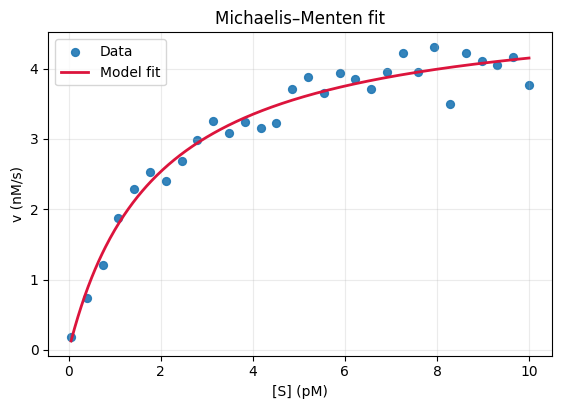

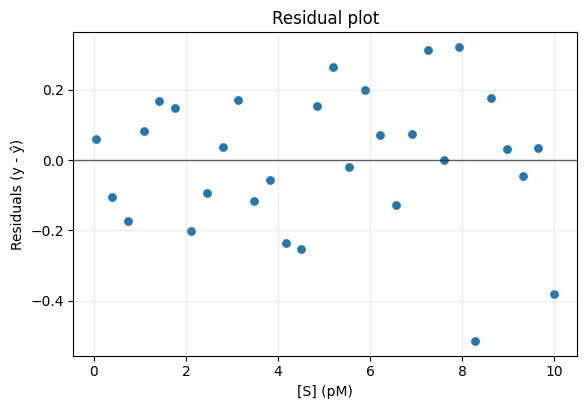

In [5]:

# ----- Generate synthetic data -----
S = np.linspace(0.05, 10.0, 30)
Vmax_true, Km_true = 5.0, 2.0
v = Vmax_true * S / (Km_true + S) + np.random.normal(0, 0.2, size=S.size)

# ----- Model -----
def mm_model(S, Vmax, Km):
    return Vmax * S / (Km + S)

# ----- Fit -----
p0 = [1.0, 1.0]
popt, pcov = curve_fit(mm_model, S, v, p0=p0, bounds=(0, np.inf))
Vmax_fit, Km_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Vmax = {Vmax_fit:.3f} ± {perr[0]:.3f}")
print(f"Km   = {Km_fit:.3f} ± {perr[1]:.3f}")

# ----- Evaluate & plot -----
vhat = mm_model(S, *popt)
print(f"R^2 = {r2_score(v, vhat):.3f}")
print(f"AIC = {aic(v, vhat, k=2):.2f}")
plot_fit(S, v, mm_model, popt, xlabel="[S] (pM)", ylabel="v (nM/s)", title="Michaelis–Menten fit")
plot_residuals(S, v - vhat, xlabel="[S] (pM)")


### Questions related to Exercise 1

1. Do


## Excercise 2: Hill equation (ligand binding)

I expect that someo of you will have heard of the Hill equation, which is a simple model for cooperative (or non-cooperative) binding between a ligand and a macromolecule (e.g., a protein or nucleic acid).

For this exercise, I have left both the Model and the Fit parts blank for you to fill in as an exercise. You will need to define a model ```hill``` as well as write code to do the curve fitting.

Model: $Y = \dfrac{[L]^n}{K_d^n + [L]^n}$, where $n$ is the Hill (cooperativity) coefficient.

- $K_d$: apparent dissociation constant (ligand at half-occupancy)
- $n>1$: positive cooperativity; $n=1$: noncooperative; $n<1$: negative cooperativity

Please do not use generative AI for this exercise!


In [ ]:

# ----- Generate synthetic data -----
L = np.logspace(-2, 2, 40)
Kd_true, n_true = 5.0, 2.0
Y = L**n_true / (Kd_true**n_true + L**n_true) + np.random.normal(0, 0.05, size=L.size)

# ----- Model -----

def hill(L, Kd, n):
    return L**n / (Kd**n + L**n)

# ----- Fit -----
pnot = [1.0, 1.0]
popt, pcov = curve_fit(hill, L, Y, p0=pnot, bounds=(0, [np.inf, 10]))
Kd_fit, n_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Kd = {Kd_fit:.3f} ± {perr[0]:.3f}")
print(f"n  = {n_fit:.3f} ± {perr[1]:.3f}")

# ----- Evaluate & plot -----
Yhat = hill(L, *popt)
print(f"R^2 = {r2_score(Y, Yhat):.3f}")
print(f"AIC = {aic(Y, Yhat, k=2):.2f}")
plt.semilogx()
plot_fit(L, Y, hill, popt, xlabel="[L] (nM)", ylabel="Y (fraction bound)", title="Hill binding curve fit")
plot_residuals(L, Y - Yhat, xlabel="[L] (nM)")


### Questions related to Exercise 2

1. **ddd**

2. **ddd**

3. **ddd**


## Evaluating fit quality

Once you have made a fit, the next critical step is to

- **Residuals:** should be structureless and roughly homoscedastic.
- **$R^2$:** fraction of variance explained (use cautiously for nonlinear models).
- **AIC:** supports model comparison; lower is better for comparable datasets.
- **Parameter uncertainty:** use `pcov` → standard errors; consider confidence intervals.


## Optional: Save datasets to CSV
This cell regenerates the four exercise datasets and saves them as CSV files so you can practice loading from files.


In [ ]:

# Regenerate and save datasets
# Exercise 1
np.random.seed(0)
t = np.linspace(0, 20, 40)
y = 50 * np.exp(-0.3 * t) + np.random.normal(0, 2.0, size=t.size)
pd.DataFrame({"t": t, "y": y}).to_csv("exercise1_decay.csv", index=False)

# Exercise 2
np.random.seed(2)
t = np.linspace(0, 12, 50)
K_true, r_true, t0_true = 1.0, 1.2, 6.0
y = K_true / (1 + np.exp(-r_true * (t - t0_true))) + np.random.normal(0, 0.05, size=t.size)
pd.DataFrame({"t": t, "y": y}).to_csv("exercise2_logistic.csv", index=False)

# Exercise 3
S = np.linspace(0.1, 15, 25)
v = 8 * S / (3 + S) + np.random.normal(0, 0.3, size=S.size)
pd.DataFrame({"S": S, "v": v}).to_csv("exercise3_mm.csv", index=False)

# Exercise 4
L = np.logspace(-1, 2, 30)
Y = L**1.8 / (7**1.8 + L**1.8) + np.random.normal(0, 0.03, size=L.size)
pd.DataFrame({"L": L, "Y": Y}).to_csv("exercise4_hill.csv", index=False)

print("Saved: exercise1_decay.csv, exercise2_logistic.csv, exercise3_mm.csv, exercise4_hill.csv")
